Implement V-type atom system

In [152]:
import numpy as np
from qutip import *
import matplotlib.pyplot as plt
from scipy.optimize import linear_sum_assignment

In [142]:
plt.rcParams.update({
    # LaTeX rendering and font configuration
    "text.usetex": True,
    "font.family": "serif",
    "font.serif": ["Palatino"],  # mathpazo corresponds to Palatino font
    "font.size": 18,  # Base font size
    
    # Font sizes for specific elements
    "axes.titlesize": 22,        # Axis title
    "axes.labelsize": 20,         # Axis labels
    "xtick.labelsize": 18,        # X-ticks
    "ytick.labelsize": 18,        # Y-ticks
    "legend.fontsize": 18,        # Legend
    "figure.titlesize": 24,       # Figure title
    
    # LaTeX preamble packages
    "text.latex.preamble": r"""
        \usepackage{amsmath}
        \usepackage{amsfonts}
        \usepackage{amssymb}
        \usepackage{lmodern}
        \usepackage{mathpazo}
    """
})

In [143]:
# -------------------------------
# 1. Define Parameters
# -------------------------------
Delta   = 0.0          # Cavity detuning 
Delta1  = 0.1          # Detuning for excited state 1
Delta2  = 0.1          # Detuning for excited state 2
g       = 0.1          # Coupling strength
phi     = 0    # Phase for the second interaction term
eta     = 0.5*g         # Amplitude for the pump term
kappa  = 1.0

# Number of atoms in the system
N_atoms = 2           # Change this to run for N atoms

# Field mode parameters
N_cutoff = 10         # Hilbert space truncation for the bosonic mode

# -------------------------------
# 2. Build the Hilbert Spaces and Field Operators
# -------------------------------
# Create the bosonic mode operators in the Fock basis
a    = destroy(N_cutoff)       # annihilation operator for the cavity field
adag = a.dag()                    # creation operator

# Identity for the field Hilbert space
I_field = qeye(N_cutoff)

# Three-level atomic  Hilbert space
dim_atom = 3

# The total atomic Hilbert space is the tensor product of N_atoms copies
atoms_identity = tensor([qeye(dim_atom)] * N_atoms)

In [144]:

# -------------------------------
# 3. Define the Gell-Mann Matrices for SU(3)
# -------------------------------
# Standard definitions (using the conventional normalization)
# Note: The Gell-Mann matrices are 3x3 numpy arrays that we wrap with Qobj.

# lambda1:
lambda1 = 1/2*Qobj([[0, 1, 0],
                   [1, 0, 0],
                   [0, 0, 0]], dims=[[3],[3]])

# lambda2:
lambda2 = 1/2*Qobj([[0, -1j, 0],
                   [1j,  0, 0],
                   [0,   0, 0]], dims=[[3],[3]])

# lambda3:
lambda3 = 1/2*Qobj([[1, 0, 0],
                   [0,-1, 0],
                   [0, 0, 0]], dims=[[3],[3]])

# lambda4:
lambda4 = 1/2*Qobj([[0, 0, 1],
                   [0, 0, 0],
                   [1, 0, 0]], dims=[[3],[3]])

# lambda5:
lambda5 = 1/2*Qobj([[0, 0, -1j],
                   [0, 0,  0],
                   [1j,0,  0]], dims=[[3],[3]])

# lambda6:
lambda6 = 1/2*Qobj([[0, 0, 0],
                   [0, 0, 1],
                   [0, 1, 0]], dims=[[3],[3]])

# lambda7:
lambda7 = 1/2*Qobj([[0, 0, 0],
                   [0, 0, -1j],
                   [0, 1j, 0]], dims=[[3],[3]])

# lambda8:
lambda8 = 1/2*(1/np.sqrt(3)) * Qobj([[1, 0, 0],
                                    [0, 1, 0],
                                    [0, 0,-2]], dims=[[3],[3]])



In [161]:
# -------------------------------
# 4. Define the Number Operators for the Atomic Levels
# -------------------------------

# Note: These are not the pure projectors onto the bare atomic states!
N1_op_local = (qeye(dim_atom)/3) + lambda3 + (1/np.sqrt(3))*lambda8
N0_op_local = (qeye(dim_atom)/3) - lambda3 + (1/np.sqrt(3))*lambda8
N2_op_local = (qeye(dim_atom)/3) - (1/np.sqrt(3))*lambda8

# -------------------------------
# 5. Helper Function to Embed a Single-Atom Operator Into the Multiatom Space
# -------------------------------
def operator_on_atom(local_op, j, N):
    """
    Returns the operator acting as local_op on the j-th atom and as the identity on others.
    local_op: Qobj for a single atom operator.
    j: integer index (0-indexed) indicating which atom.
    N: total number of atoms.
    """
    op_list = []
    for k in range(N):
        if k == j:
            op_list.append(local_op)
        else:
            op_list.append(qeye(dim_atom))
    return tensor(op_list)

# -------------------------------
# 6. Define a Function to Build the Hamiltonian for a Given phi
# -------------------------------
def build_hamiltonian(N_atoms, phi):
    """ 
    Returns the many-body Hamiltonian for a system with N atoms and a given phase
    
    """
    
    
    atoms_identity = tensor([qeye(dim_atom)] * N_atoms) 
    # (a) Field (cavity) term: -Delta * a^\dagger a
    H_field = -Delta * tensor(adag * a, atoms_identity)
    
    # (b) Atomic detuning terms: sum over atoms of -Delta_m * N_m operators.
    H_atom = 0
    for j in range(N_atoms):
        op_N1_j = operator_on_atom(N1_op_local, j, N_atoms)
        op_N2_j = operator_on_atom(N2_op_local, j, N_atoms)
        H_atom += -Delta1 * tensor(I_field, op_N1_j) - Delta2 * tensor(I_field, op_N2_j)
    
    # (c) Interaction term for each atom:
    # Define the two local interaction operators on the atomic space:
    op1_local = lambda1 - 1j * lambda2
    op2_local = lambda6 - 1j * lambda7
    
    H_int = 0
    for j in range(N_atoms):
        op1_j = operator_on_atom(op1_local, j, N_atoms)
        op2_j = operator_on_atom(op2_local, j, N_atoms)
        term = tensor(adag, op1_j) + np.exp(-1j*phi) * tensor(adag, op2_j)
        # Add the Hermitian conjugate so that the interaction is self-adjoint:
        H_int += g * (term + term.dag())
    
    # (d) Pump term: i * eta * (a^\dagger - a) acting on the field only.
    H_pump = 1j * eta * tensor(adag - a, atoms_identity)
    
    # Total Hamiltonian:
    return H_field + H_atom + H_int + H_pump

# -------------------------------
# 7. Define the Collapse Operators
# -------------------------------
# Cavity decay collapse operator.
c_ops = [np.sqrt(kappa) * tensor(a, atoms_identity)]


In [172]:
H = build_hamiltonian(2, 0)

In [177]:
# Solve the system for an initial state |0> for the atoms and |0> for the cavity field

psiat = tensor([basis(dim_atom, 0)] * N_atoms)  # All atoms in |0> state
psicav = basis(N_cutoff, 0)  # Field in |0> state
psi0 = tensor(psicav,psiat)

Rho0 = psi0 * psi0.dag()

tspan = np.linspace(0,10,100)

result0 = mesolve(H, Rho0, tspan, c_ops, [])

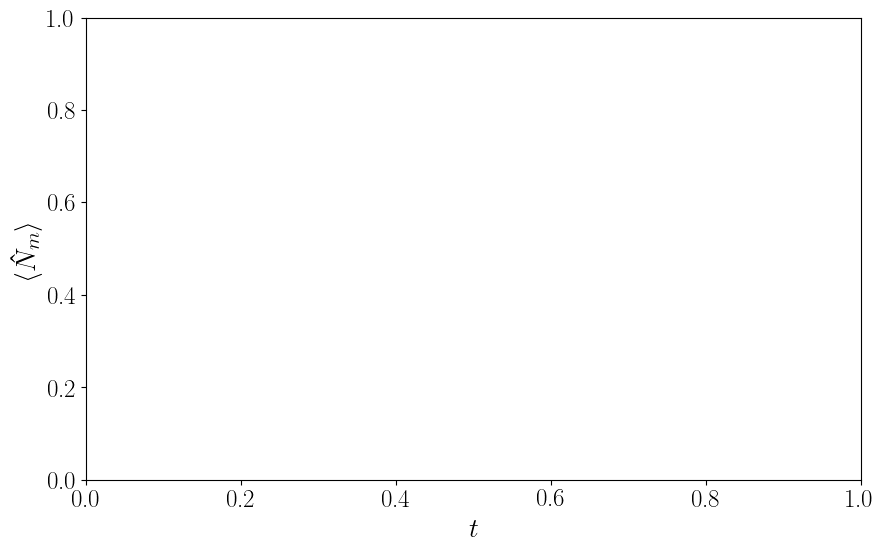

In [180]:
#Plot expectation values of relative populations of the atomic states

fig, ax = plt.subplots(figsize=(10,6))
ax.set_xlabel(r"$t$")
ax.set_ylabel(r"$\langle \hat{N}_m \rangle$")
plt.show()